In [1]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  error: subprocess-exited-with-error
  
  × Running setup.py install for tensorflow-gpu did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for tensorflow-gpu ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> tensorflow-gpu

note: This i

# Import libraries

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt
# Do some data transformation
import numpy as np
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU,ReLU, Dropout, UpSampling2D,Conv2DTranspose,BatchNormalization
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [3]:
%load_ext tensorboard

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Download Dataset

show and check some images

228813984/228813984 [==============================] - 6s 0us/step
Found 3670 files belonging to 1 classes.
(128, 64, 64, 3)
(64, 64, 3)
255.0 0.0
<dtype: 'float32'>


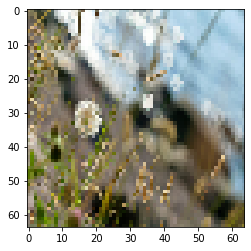

(128, 64, 64, 3)
(64, 64, 3)
225.62695 7.133789
<dtype: 'float32'>


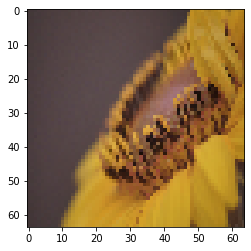

In [5]:

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode=None,
  seed=123,
  image_size=(64, 64),
  batch_size=128
)

for images in train_ds.take(2):
  print(images.shape)
  print(images[0].shape)
  print(np.max(images[0]),np.min(images[0]))
  print(images[0].dtype)
  x=np.array(images[0])
  plt.imshow(x.astype('uint8'))
  plt.show()

# Preprocessing and prepare data to feed model

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(128, 64, 64, 3)
(64, 64, 3)
254.09164 0.0
<dtype: 'float32'>


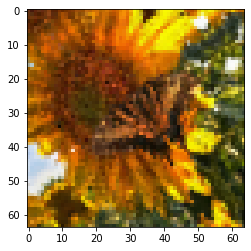

(128, 64, 64, 3)
(64, 64, 3)
239.72888 5.632227
<dtype: 'float32'>


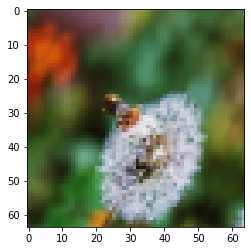

(128, 64, 64, 3)
(64, 64, 3)
0.90630144 -1.0
<dtype: 'float32'>


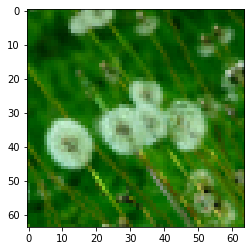

In [6]:
max_translation = 0.125
max_rotation = 0.125


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=max_rotation)

             ])

train_ds = train_ds.map(lambda x: data_augmentation(x))
for images in train_ds.take(2):
  print(images.shape)
  print(images[0].shape)
  print(np.max(images[0]),np.min(images[0]))
  print(images[0].dtype)
  x=np.array(images[0])
  plt.imshow(x.astype('uint8'))
  plt.show()


def scale_images(image): 
    image = (image - 127.5) / 127.5
    return image
train_ds = train_ds.map(scale_images) 

for images in train_ds.take(1):
  print(images.shape)
  print(images[0].shape)
  print(np.max(images[0]),np.min(images[0]))
  print(images[0].dtype)
  x=np.array(images[0])
  plt.imshow(images[0]* 0.5 + 0.5)
  plt.show()

In [7]:
train_ds = train_ds.prefetch(64)

# Define generator 

In [8]:
filter_size = 5
num_filters = 64
noise_dim = 100

def build_generator():
    model = tf.keras.Sequential()

    model.add(Dense(4*4*512, input_shape=(noise_dim,)))
    model.add(Reshape((4, 4, 512)))

    model.add(Conv2DTranspose(num_filters*4, filter_size))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(num_filters*2, filter_size, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(num_filters, filter_size, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(3, filter_size, strides=2, padding='same', activation='tanh'))

    return model
generator = build_generator()
generator.summary()    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)     

# Define discriminator

In [9]:
dropout_prob = 0.5
num_filters = 64
filter_size = 5
leaky_slope = 0.2


def build_discriminator(): 
    model = tf.keras.Sequential()


    model.add(Dropout(dropout_prob, input_shape=(64, 64, 3)))

    model.add(Conv2D(num_filters, filter_size, strides=2, padding='same'))
    model.add(LeakyReLU(leaky_slope))
    
    model.add(Conv2D(num_filters, filter_size*2, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(leaky_slope))

    model.add(Conv2D(num_filters, filter_size*4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(leaky_slope))

    model.add(Conv2D(num_filters, filter_size*8, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(leaky_slope))

    model.add(Conv2D(1, 4, strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model
discriminator = build_discriminator()
discriminator.summary()    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        409664    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                      

# Define loss functions and optimizers

In [10]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# Create subclass model

In [11]:
class DCGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 
    @tf.function
    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 100, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            # noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            # noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            # y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,100,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

# Create instance of subclassed model
# and compile the model

In [12]:

gan = DCGAN(generator, discriminator)

gan.compile(g_opt, d_opt, g_loss, d_loss)

# Define callbacks for TensorBoard

In [13]:
import datetime
from keras.callbacks import ModelCheckpoint
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
filepath = '/content/drive/MyDrive/'
# checkpoint = ModelCheckpoint(filepath,monitor="loss", verbose=1,  mode='min',save_freq=100)

# Fit the model

In [14]:
hist = gan.fit(train_ds, epochs=1000, callbacks=[tensorboard_callback])
gan.save_weights(filepath, save_format=None, options=None)

Epoch 1/1000
29/29 [==============================] - 37s 578ms/step - d_loss: 0.3932 - g_loss: 0.6548
Epoch 2/1000
29/29 [==============================] - 19s 632ms/step - d_loss: 0.1487 - g_loss: 0.4793
Epoch 3/1000
29/29 [==============================] - 19s 615ms/step - d_loss: 0.0922 - g_loss: 0.1777
Epoch 4/1000
29/29 [==============================] - 19s 609ms/step - d_loss: 0.0296 - g_loss: 0.0204
Epoch 5/1000
29/29 [==============================] - 20s 660ms/step - d_loss: 0.0051 - g_loss: 8.2189e-04
Epoch 6/1000
29/29 [==============================] - 19s 612ms/step - d_loss: 0.0023 - g_loss: 1.7913e-05
Epoch 7/1000
29/29 [==============================] - 20s 607ms/step - d_loss: 0.0017 - g_loss: 2.8897e-07
Epoch 8/1000
29/29 [==============================] - 19s 629ms/step - d_loss: 0.0013 - g_loss: 5.4789e-09
Epoch 9/1000
29/29 [==============================] - 19s 610ms/step - d_loss: 0.0011 - g_loss: 2.9651e-10
Epoch 10/1000
29/29 [==============================] 

# Show some generated images

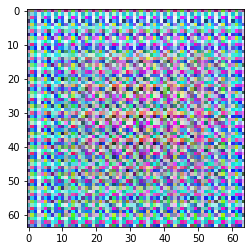

(1, 64, 64, 3)


In [15]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, :] *.5+.5)
plt.show()
print(generated_image.shape) 

1/1 [==============================] - 0s 316ms/step


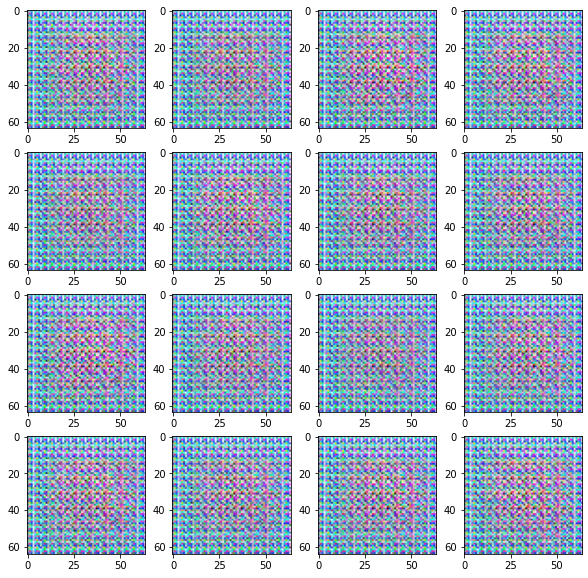

In [16]:
imgs = generator.predict(tf.random.normal((16, 100, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4):

        ax[r][c].imshow(imgs[(r+1)*(c+1)-1]* 0.5 + 0.5)